In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from itertools import combinations 
from scipy.integrate import cumtrapz
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# import utils
sys.path.append("../../../utils")
from plotting_utils import *


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## variables

In [5]:
data_f = "../../../data/02__mpra/03__results/all_processed_results.txt"

## 1. import data

In [6]:
data = pd.read_table(data_f, sep="\t")
data.head()

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,cleaner_biotype_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,...,trans_mouse_status,trans_human_status_det,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det
0,h.2,chr1,2985430.0,div_lnc,"chr1:2985420..2985438,-",ENSG00000177133.6,div. lncRNA,lncRNA,0.07111110000000001,m.1,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.333118,-0.035380,0.988785,no cis/trans int. effect,no cis/trans int. effect
1,h.3,chr1,8086552.0,div_lnc,"chr1:8086546..8086571,+",ENSG00000238290.1,div. lncRNA,lncRNA,0.10444400000000001,m.2,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.536610,-0.387857,0.921562,no cis/trans int. effect,no cis/trans int. effect
2,h.4,chr1,26498322.0,antisense_upep,"chr1:26498321..26498327,-",ENSG00000236782.1,other lncRNA,lncRNA,0.03,m.3,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.260673,-0.192854,0.959265,no cis/trans int. effect,no cis/trans int. effect
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lincRNA,lncRNA,0.841111,m.4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.439975,-0.723633,0.197618,no cis/trans int. effect,no cis/trans int. effect
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lincRNA,lncRNA,0.116667,m.4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.267503,-0.511763,0.453490,no cis/trans int. effect,no cis/trans int. effect


## 2. filter data

In [7]:
data = data[~pd.isnull(data["minimal_biotype_hg19"])]
len(data)

4944

In [8]:
data_filt = data[((data["HUES64_padj_hg19"] < QUANT_ALPHA) | (data["mESC_padj_mm9"] < QUANT_ALPHA))]
len(data_filt)

2070

In [9]:
data_filt_sp = data_filt.drop("orig_species", axis=1)
data_filt_sp.drop_duplicates(inplace=True)
len(data_filt_sp)

2059

In [10]:
data_filt_tile1 = data_filt[data_filt["tss_tile_num"] == "tile1"]
len(data_filt_tile1)

1409

In [11]:
data_filt_tile1_sp = data_filt_sp[data_filt_sp["tss_tile_num"] == "tile1"]
len(data_filt_tile1_sp)

1399

In [12]:
data_filt_tile2 = data_filt[data_filt["tss_tile_num"] == "tile2"]
len(data_filt_tile2)

661

In [13]:
data_filt_tile2_sp = data_filt_sp[data_filt_sp["tss_tile_num"] == "tile2"]
len(data_filt_tile2_sp)

660

## count of cis/trans/both

In [14]:
len(data_filt_sp)

2059

In [15]:
len(data_filt_sp[(data_filt_sp["cis_status_one"] != "no cis effect") & (data_filt_sp["trans_status_one"] == "no trans effect")])

635

In [16]:
len(data_filt_sp[(data_filt_sp["cis_status_one"] == "no cis effect") & (data_filt_sp["trans_status_one"] != "no trans effect")])


151

In [17]:
len(data_filt_sp[(data_filt_sp["cis_status_one"] != "no cis effect") & (data_filt_sp["trans_status_one"] != "no trans effect")])

192

## 3. count of cis/trans interactions

In [18]:
int_order = ["no cis/trans int. effect", "significant cis/trans int. effect"]
int_pal = {"no cis/trans int. effect": "gray", "significant cis/trans int. effect": "black"}

In [19]:
dfs = [data_filt_sp, data_filt_tile1_sp, data_filt_tile2_sp]
titles = ["both tiles", "tile1 only", "tile2 only"]
labels = ["both_tiles", "tile1_only", "tile2_only"]

percent cis/trans sig: 0.026711996114618747


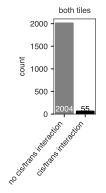

percent cis/trans sig: 0.02573266619013581


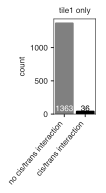

percent cis/trans sig: 0.02878787878787879


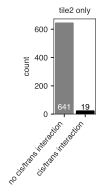

In [20]:
for df, title, label in zip(dfs, titles, labels):
    
    fig, ax = plt.subplots(figsize=(0.75, 1.75), nrows=1, ncols=1)

    sns.countplot(data=df, x="cis_trans_int_status", palette=int_pal, order=int_order, linewidth=2, 
                  edgecolor=int_pal.values(), ax=ax)
    ax.set_xticklabels(["no cis/trans interaction", "cis/trans interaction"], va="top", ha="right", rotation=50)
    ax.set_xlabel("")
    ax.set_title(title)
    
    tot = 0
    colors = ["white", "black"]
    for i, l in enumerate(int_order):
        n = len(df[df["cis_trans_int_status"] == l])
        tot += n
        ax.annotate(str(n), xy=(i, 20), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=colors[i], size=fontsize)
    print("percent cis/trans sig: %s" % (n/tot))

    plt.show()
    fig.savefig("count_cistrans_status.%s.pdf" % label, dpi="figure", bbox_inches="tight")
    plt.close()

## 5. effect size differences across biotypes

In [21]:
min_switch_order = ["CAGE turnover - eRNA", "CAGE turnover - lncRNA", "CAGE turnover - mRNA", 
                    "eRNA", "lncRNA", "mRNA"]

CAGE turnover - eRNA median eff size: 0.316158134983999
CAGE turnover - lncRNA median eff size: 0.292282867780932
CAGE turnover - mRNA median eff size: 0.408804963735766
eRNA median eff size: 0.323970389768894
lncRNA median eff size: 0.247311364002222
mRNA median eff size: 0.251157243751525


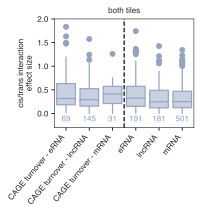

CAGE turnover - eRNA median eff size: 0.3095997854393815
CAGE turnover - lncRNA median eff size: 0.28193206885877803
CAGE turnover - mRNA median eff size: 0.408804963735766
eRNA median eff size: 0.32856342975436803
lncRNA median eff size: 0.21363850068725895
mRNA median eff size: 0.24181043229692


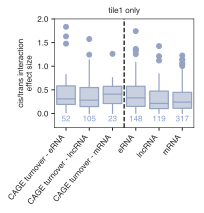

CAGE turnover - eRNA median eff size: 0.5261161661466071
CAGE turnover - lncRNA median eff size: 0.3103820233908565
CAGE turnover - mRNA median eff size: 0.4041529889397545
eRNA median eff size: 0.308986240626728
lncRNA median eff size: 0.3309742768766545
mRNA median eff size: 0.28422313613182304


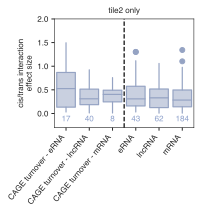

In [22]:
for df, title, label in zip(dfs, titles, labels):
    df["abs_logFC_int"] = np.abs(df["logFC_int"])
    #df = df[df["native_status"] == "significant native effect"]

    fig = plt.figure(figsize=(2.5, 2))
    ax = sns.boxplot(data=df, x="biotype_switch_minimal", y="abs_logFC_int", 
                     flierprops = dict(marker='o', markersize=5), 
                     order=min_switch_order, color=sns.color_palette("Set2")[2])
    mimic_r_boxplot(ax)

    ax.set_xticklabels(min_switch_order, rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel("cis/trans interaction\neffect size")
    ax.set_title(title)

    for i, l in enumerate(min_switch_order):
        sub = df[df["biotype_switch_minimal"] == l]
        n = len(sub)
        print("%s median eff size: %s" % (l, sub["abs_logFC_int"].median()))
        color = sns.color_palette("Set2")[2]
        ax.annotate(str(n), xy=(i, -0.2), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=color, size=fontsize)

    ax.set_ylim((-0.3, 2))
    ax.axvline(x=2.5, linestyle="dashed", color="black")

    plt.show()
    fig.savefig("cistrans_minimal_biotype_switch_effectsize_boxplot.%s.pdf" % label, dpi="figure", bbox_inches="tight")
    plt.close()

## 6. percent sig across biotypes

CAGE turnover - eRNA perc sig: 10.1449275362
CAGE turnover - lncRNA perc sig: 2.06896551724
CAGE turnover - mRNA perc sig: 0.0
eRNA perc sig: 6.80628272251
lncRNA perc sig: 0.552486187845
mRNA perc sig: 1.99600798403


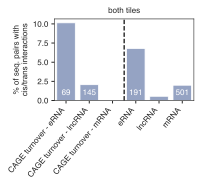

CAGE turnover - eRNA perc sig: 5.76923076923
CAGE turnover - lncRNA perc sig: 2.85714285714
CAGE turnover - mRNA perc sig: 0.0
eRNA perc sig: 6.75675675676
lncRNA perc sig: 0.840336134454
mRNA perc sig: 2.20820189274


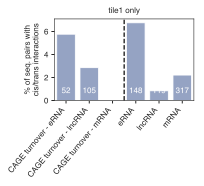

CAGE turnover - eRNA perc sig: 23.5294117647
CAGE turnover - lncRNA perc sig: 0.0
CAGE turnover - mRNA perc sig: 0.0
eRNA perc sig: 6.97674418605
lncRNA perc sig: 0.0
mRNA perc sig: 1.63043478261


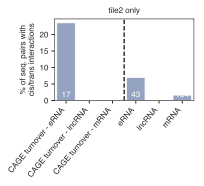

In [23]:
for df, title, label in zip(dfs, titles, labels):

    tots = df.groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
    sig = df[df["cis_trans_int_status"] != "no cis/trans int. effect"].groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
    clean_sig = tots.merge(sig, on="biotype_switch_minimal", how="left").fillna(0)
    clean_sig["percent_sig"] = (clean_sig["hg19_id_y"]/clean_sig["hg19_id_x"])*100
    
    fig = plt.figure(figsize=(2.5, 1.5))
    ax = sns.barplot(data=clean_sig, x="biotype_switch_minimal", y="percent_sig", 
                     order=min_switch_order, color=sns.color_palette("Set2")[2])

    ax.set_xticklabels(min_switch_order, rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel("% of seq. pairs with\ncis/trans interactions")
    ax.set_title(title)
    ax.axvline(x=2.5, linestyle="dashed", color="black")
    
    for i, l in enumerate(min_switch_order):
        sub = clean_sig[clean_sig["biotype_switch_minimal"] == l]
        print("%s perc sig: %s" % (l, sub["percent_sig"].iloc[0]))
        n = sub["hg19_id_x"].iloc[0]
        ax.annotate(str(n), xy=(i, 0.5), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color="white", size=fontsize)
    
    plt.show()
    fig.savefig("perc_sig_cistrans_minimal_biotype_switch.%s.pdf" % label, dpi="figure", bbox_inches="tight")
    plt.close()

## 7. look generally at significant interactions

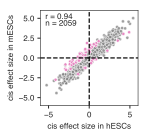

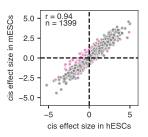

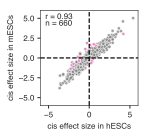

In [24]:
for df, title, label in zip(dfs, titles, labels):
    
    # plot effect size agreement b/w the two cells
    fig, ax = plt.subplots(figsize=(1.75, 1.75), nrows=1, ncols=1)

    sig_int = df[df["cis_trans_int_status"] != "no cis/trans int. effect"]
    not_sig_int = df[df["cis_trans_int_status"] == "no cis/trans int. effect"]

    ax.scatter(not_sig_int["logFC_cis_HUES64"], not_sig_int["logFC_cis_mESC"], s=10, alpha=0.75, 
               color="gray", linewidths=0.5, edgecolors="white")
    ax.scatter(sig_int["logFC_cis_HUES64"], sig_int["logFC_cis_mESC"], s=10, alpha=1, 
               color=sns.color_palette("Set2")[3], linewidths=0.5, edgecolors="white")

    plt.xlabel("cis effect size in hESCs")
    plt.ylabel("cis effect size in mESCs")

    ax.axhline(y=0, color="black", linestyle="dashed")
    ax.axvline(x=0, color="black", linestyle="dashed")
    ax.set_xlim((-6, 6))
    ax.set_ylim((-6, 6))

    # annotate corr
    no_nan = df[(~pd.isnull(df["logFC_cis_HUES64"])) & (~pd.isnull(df["logFC_cis_mESC"]))]
    r, p = spearmanr(no_nan["logFC_cis_HUES64"], no_nan["logFC_cis_mESC"])
    ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
            transform=ax.transAxes)
    ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
            transform=ax.transAxes)
    plt.show()
    #fig.savefig("cis_effect_bw_cells_scatter.sig_status_color.%s.pdf" % label, dpi="figure", bbox_inches="tight")
    plt.close()

## 8. look at highest cis/trans interactions

In [25]:
sig_int = data_filt_tile1_sp[data_filt_tile1_sp["cis_trans_int_status"] != "no cis/trans int. effect"]
len(sig_int)

36

In [26]:
sig_int_filt = sig_int[((sig_int["logFC_cis_HUES64"] < 0) & (sig_int["logFC_cis_mESC"] > 0)) |
                       ((sig_int["logFC_cis_HUES64"] > 0) & (sig_int["logFC_cis_mESC"] < 0))]
len(sig_int_filt)

12

In [27]:
sub = sig_int_filt[["hg19_id", "mm9_id", "biotype_hg19", "biotype_mm9", "biotype_switch_minimal", "logFC_int", "logFC_cis_HUES64", "logFC_cis_mESC",
                    "HUES64_hg19", "mESC_hg19", "HUES64_mm9", "mESC_mm9"]]
sub

,hg19_id,mm9_id,biotype_hg19,biotype_mm9,biotype_switch_minimal,logFC_int,logFC_cis_HUES64,logFC_cis_mESC,HUES64_hg19,mESC_hg19,HUES64_mm9,mESC_mm9
143,h.229,m.147,intergenic,intergenic_upep,lncRNA,1.425875,-0.938427,0.590523,10.111847,3.044591,10.292323,13.895768
271,h.411,m.275,antisense,enhancer,biotype switch,1.313664,-0.848872,0.455385,2.640678,0.932782,1.181024,1.818922
674,h.996,m.879,div_pc,protein_coding,mRNA,1.138308,-0.716368,0.339488,3.462738,1.701346,10.858340,16.933102
744,h.1110,m.992,div_pc,protein_coding,mRNA,-1.068006,0.831617,-0.177236,5.635690,5.012061,7.331415,2.278838
1057,h.1305,m.1177,enhancer,enhancer,eRNA,1.741547,-1.165773,0.543635,4.358576,1.042897,0.752877,1.038966
1076,h.1505,m.1323,enhancer,enhancer,eRNA,1.072183,-1.020897,0.039833,2.127216,0.863598,0.776390,0.801444
1139,h.1564,m.1376,antisense_upep,no cage activity,reclassified,1.209948,-1.006702,0.077974,3.292293,1.400337,0.913602,1.272295
1308,h.1830,m.1642,div_lnc,no cage activity,reclassified,1.216996,-0.424073,0.719570,4.497318,2.549467,2.220807,4.020198
1395,h.1949,m.1761,intergenic,no cage activity,reclassified,1.446206,-0.502109,1.011612,14.917626,3.449028,3.353794,3.351709
1685,h.2369,m.2181,protein_coding,no cage activity,reclassified,0.850362,-0.473975,0.349007,5.518816,2.366826,1.607261,1.521938


In [28]:
pal = {"hg19": sns.color_palette("Set2")[1], "mm9": sns.color_palette("Set2")[0]}

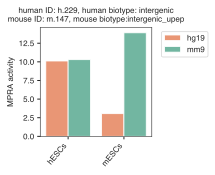

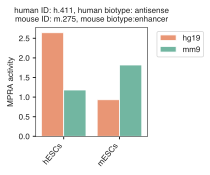

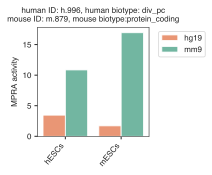

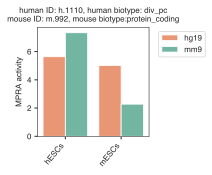

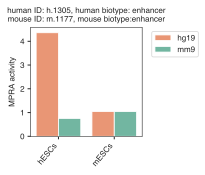

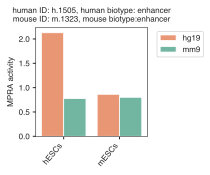

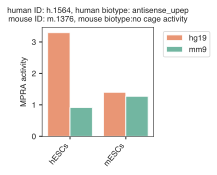

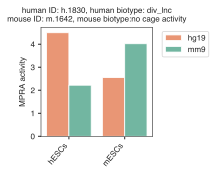

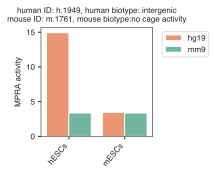

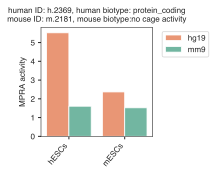

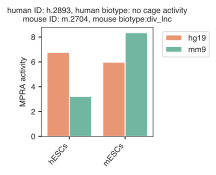

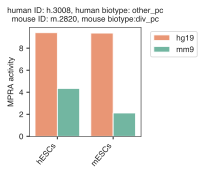

In [29]:
for row in sub.iterrows():
    samp = pd.DataFrame(row[1]).T
    melt = pd.melt(samp, id_vars=["hg19_id", "mm9_id", "biotype_hg19", "biotype_mm9", "biotype_switch_minimal", 
                                  "logFC_int", "logFC_cis_HUES64", "logFC_cis_mESC"])
    melt["cell"] = melt["variable"].str.split("_", expand=True)[0]
    melt["seq"] = melt["variable"].str.split("_", expand=True)[1]
    
    fig = plt.figure(figsize=(2, 2))
    ax = sns.barplot(data=melt, x="cell", hue="seq", y="value", palette=pal)
    ax.set_ylabel("MPRA activity")
    ax.set_xlabel("")
    ax.set_xticklabels(["hESCs", "mESCs"], rotation=50, ha='right', va='top')
    ax.set_title("human ID: %s, human biotype: %s\nmouse ID: %s, mouse biotype:%s" % (row[1].hg19_id, 
                                                                                      row[1].biotype_hg19, 
                                                                                      row[1].mm9_id,
                                                                                      row[1].biotype_mm9))
    plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
    plt.show()
    plt.close()
    fig.savefig("%s.%s.barplot.pdf" % (row[1].hg19_id, row[1].mm9_id), dpi="figure", bbox_inches="tight")

## 9. look at cis/trans when subsetting by native

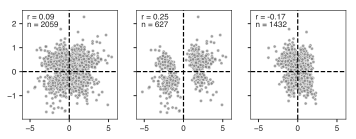

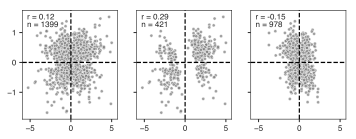

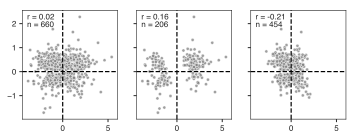

In [30]:
for df, title, label in zip(dfs, titles, labels):
    
    fig, axarr = plt.subplots(figsize=(5.8, 2), nrows=1, ncols=3, sharex=True, sharey=True)
    
    # all seqs
    ax = axarr[0]
    ax.scatter(df["logFC_cis_one"], df["logFC_trans_one"], s=10, alpha=0.75, 
               color="gray", linewidths=0.5, edgecolors="white")

    plt.xlabel("cis effect size")
    plt.ylabel("trans effect size")

    ax.axhline(y=0, color="black", linestyle="dashed")
    ax.axvline(x=0, color="black", linestyle="dashed")

    # annotate corr
    no_nan = df[(~pd.isnull(df["logFC_cis_one"])) & (~pd.isnull(df["logFC_trans_one"]))]
    r, p = spearmanr(no_nan["logFC_cis_one"], no_nan["logFC_trans_one"])
    ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
            transform=ax.transAxes)
    ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
            transform=ax.transAxes)
    
    # native effects only
    sub = df[df["native_status"] == "significant native effect"]
    ax = axarr[1]
    ax.scatter(sub["logFC_cis_one"], sub["logFC_trans_one"], s=10, alpha=0.75, 
               color="gray", linewidths=0.5, edgecolors="white")

    plt.xlabel("cis effect size")
    plt.ylabel("trans effect size")

    ax.axhline(y=0, color="black", linestyle="dashed")
    ax.axvline(x=0, color="black", linestyle="dashed")

    # annotate corr
    no_nan = sub[(~pd.isnull(sub["logFC_cis_one"])) & (~pd.isnull(sub["logFC_trans_one"]))]
    r, p = spearmanr(no_nan["logFC_cis_one"], no_nan["logFC_trans_one"])
    ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
            transform=ax.transAxes)
    ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
            transform=ax.transAxes)
    
    # no native effects
    sub = df[df["native_status"] == "no native effect"]
    ax = axarr[2]
    ax.scatter(sub["logFC_cis_one"], sub["logFC_trans_one"], s=10, alpha=0.75, 
               color="gray", linewidths=0.5, edgecolors="white")

    plt.xlabel("cis effect size")
    plt.ylabel("trans effect size")

    ax.axhline(y=0, color="black", linestyle="dashed")
    ax.axvline(x=0, color="black", linestyle="dashed")

    # annotate corr
    no_nan = sub[(~pd.isnull(sub["logFC_cis_one"])) & (~pd.isnull(sub["logFC_trans_one"]))]
    r, p = spearmanr(no_nan["logFC_cis_one"], no_nan["logFC_trans_one"])
    ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
            transform=ax.transAxes)
    ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
            transform=ax.transAxes)
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    fig.savefig("cis_v_trans.%s.pdf" % label, dpi="figure", bbox_inches="tight")

## 10. look at invidiual directionality of cis/trans

In [31]:
df.columns

Index(['hg19_id', 'chr_tss_hg19', 'start_tss_hg19', 'biotype_hg19',
       'cage_id_hg19', 'name_peak_hg19', 'cleaner_biotype_hg19',
       'minimal_biotype_hg19', 'stem_exp_hg19', 'mm9_id', 'chr_tss_mm9',
       'start_tss_mm9', 'biotype_mm9', 'cage_id_mm9', 'name_peak_mm9',
       'cleaner_biotype_mm9', 'minimal_biotype_mm9', 'stem_exp_mm9',
       'tss_tile_num', 'biotype_switch_clean', 'biotype_switch_minimal',
       'HUES64_hg19', 'mESC_hg19', 'HUES64_mm9', 'mESC_mm9',
       'HUES64_padj_hg19', 'mESC_padj_hg19', 'HUES64_padj_mm9',
       'mESC_padj_mm9', 'logFC_native', 'fdr_native', 'native_status',
       'native_status_det', 'logFC_cis_HUES64', 'fdr_cis_HUES64',
       'logFC_cis_mESC', 'fdr_cis_mESC', 'cis_HUES64_status',
       'cis_mESC_status', 'cis_HUES64_status_det', 'cis_mESC_status_det',
       'cis_status_one', 'cis_status_det_one', 'logFC_cis_one',
       'logFC_trans_human', 'fdr_trans_human', 'logFC_trans_mouse',
       'fdr_trans_mouse', 'trans_human_status', 'tr

192
133
59


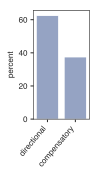

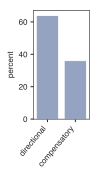

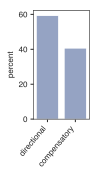

In [32]:
for df, title, label in zip(dfs, titles, labels):
    res = {}
    cis_trans = df[(df["cis_status_one"] == "significant cis effect") & 
                   (df["trans_status_one"] == "significant trans effect")]
    tots = len(cis_trans)
    print(tots)
    res["total"] = [tots]
    direc = cis_trans[((cis_trans["cis_status_det_one"].str.contains("higher in human") & 
                        cis_trans["trans_status_det_one"].str.contains("higher in human")) |
                       (cis_trans["cis_status_det_one"].str.contains("higher in mouse") &
                        cis_trans["trans_status_det_one"].str.contains("higher in mouse")))]    
    direc = len(direc)
    res["directional"] = [direc]

    comp = cis_trans[((cis_trans["cis_status_det_one"].str.contains("higher in human") & 
                        cis_trans["trans_status_det_one"].str.contains("higher in mouse")) |
                       (cis_trans["cis_status_det_one"].str.contains("higher in mouse") &
                        cis_trans["trans_status_det_one"].str.contains("higher in human")))]
    comp = len(comp)
    res["compensatory"] = [comp]
    res = pd.DataFrame.from_dict(res, orient="index").reset_index()
    res["perc"] = (res[0]/tots)*100
    
    order = ["directional", "compensatory"]
    fig, ax = plt.subplots(figsize=(1, 2), nrows=1, ncols=1)
    
    sns.barplot(data=res, x="index", y="perc", order=order, color=sns.color_palette("Set2")[2], ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("percent")
    ax.set_xticklabels(order, rotation=50, ha="right", va="top")
    fig.savefig("direc_v_comp.%s.pdf" % label, dpi="figure", bbox_inches="tight")

CAGE turnover - eRNA perc sig: 86.6666666667
CAGE turnover - lncRNA perc sig: 66.6666666667
CAGE turnover - mRNA perc sig: 75.0
eRNA perc sig: 70.3703703704
lncRNA perc sig: 46.1538461538
mRNA perc sig: 46.3414634146


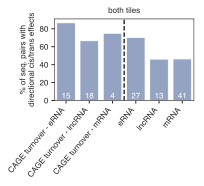

CAGE turnover - eRNA perc sig: 100.0
CAGE turnover - lncRNA perc sig: 66.6666666667
CAGE turnover - mRNA perc sig: 66.6666666667
eRNA perc sig: 78.2608695652
lncRNA perc sig: 37.5
mRNA perc sig: 41.3793103448


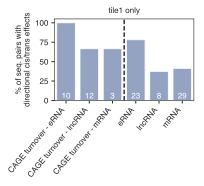

CAGE turnover - eRNA perc sig: 60.0
CAGE turnover - lncRNA perc sig: 66.6666666667
CAGE turnover - mRNA perc sig: 100.0
eRNA perc sig: 25.0
lncRNA perc sig: 60.0
mRNA perc sig: 58.3333333333


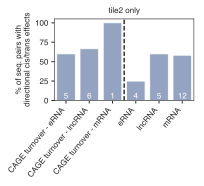

In [33]:
for df, title, label in zip(dfs, titles, labels):

    cis_trans = df[(df["cis_status_one"] == "significant cis effect") & 
                   (df["trans_status_one"] == "significant trans effect")]
    tots = cis_trans.groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
    
    direc = cis_trans[((cis_trans["cis_status_det_one"].str.contains("higher in human") & 
                        cis_trans["trans_status_det_one"].str.contains("higher in human")) |
                       (cis_trans["cis_status_det_one"].str.contains("higher in mouse") &
                        cis_trans["trans_status_det_one"].str.contains("higher in mouse")))]
    sig = direc.groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
    clean_sig = tots.merge(sig, on="biotype_switch_minimal", how="left").fillna(0)
    clean_sig["percent_sig"] = (clean_sig["hg19_id_y"]/clean_sig["hg19_id_x"])*100
    
    fig = plt.figure(figsize=(2.5, 1.5))
    ax = sns.barplot(data=clean_sig, x="biotype_switch_minimal", y="percent_sig", 
                     order=min_switch_order, color=sns.color_palette("Set2")[2])

    ax.set_xticklabels(min_switch_order, rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel("% of seq. pairs with\ndirectional cis/trans effects")
    ax.set_title(title)
    ax.axvline(x=2.5, linestyle="dashed", color="black")
    
    for i, l in enumerate(min_switch_order):
        sub = clean_sig[clean_sig["biotype_switch_minimal"] == l]
        print("%s perc sig: %s" % (l, sub["percent_sig"].iloc[0]))
        n = sub["hg19_id_x"].iloc[0]
        ax.annotate(str(n), xy=(i, 0.5), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color="white", size=fontsize)
    
    plt.show()
    fig.savefig("perc_sig_compensatory_minimal_biotype_switch.%s.pdf" % label, dpi="figure", bbox_inches="tight")
    plt.close()